In [1]:
!nvidia-smi

Sat Mar  6 08:01:40 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 410.104      Driver Version: 410.104      CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-DGXS...  On   | 00000000:07:00.0 Off |                    0 |
| N/A   43C    P0    51W / 300W |  23367MiB / 32478MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-DGXS...  On   | 00000000:08:00.0 Off |                    0 |
| N/A   41C    P0    53W / 300W |   4110MiB / 32478MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [2]:
# using gpu:/2
import tensorflow as tf
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

gpus = tf.config.experimental.list_physical_devices('GPU')

## Dataset 분할

---

`Train` : `Test` = 0.9 : 0.1

In [3]:
import os
path_dir1 = '../sungjin/face2/train/'
path_dir2 = '../sungjin/face2/test/'

sub_directory = ['with_mask/','without_mask/']

TRAIN_NUM = 0
TEST_NUM = 0

for subdir in sub_directory:
    tmp_list = os.listdir(path_dir1+subdir)
    TRAIN_NUM += len(tmp_list)
    
for subdir in sub_directory:
    tmp2_list = os.listdir(path_dir2+subdir)
    TEST_NUM += len(tmp2_list)
    

In [4]:
# the number of training data = 2989
print(TRAIN_NUM)

6045


In [5]:
# the number of test data = 331
print(TEST_NUM)

951


In [6]:
import numpy as np

train_img = np.float32(np.zeros((TRAIN_NUM,224,224,3)))
train_label = np.uint8(np.zeros((TRAIN_NUM,)))

test_img = np.float32(np.zeros((TEST_NUM,224,224,3)))
test_label = np.uint8(np.zeros((TEST_NUM,)))

## Make Label

---

1.  0 - 19세 : **0번**

2.  20 - 49세 : **1번**

3.  50세 이상 : **2번**

In [7]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.imagenet_utils import preprocess_input

make_label = [0,1]

num = 0
idx = 0
for subdir in sub_directory:
    give_label = make_label[idx]
    for file in os.listdir(path_dir1+subdir):
        src_path = path_dir1 + subdir + file
        img = load_img(src_path, target_size = (224,224))

        x = img_to_array(img)
        x = np.expand_dims(x, axis=0)
        
        train_img[num, :, :, :] = x

        train_label[num] = give_label
        num = num + 1
    idx += 1

/root/anaconda3/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [8]:
num = 0
idx = 0

for subdir in sub_directory:
    give_label = make_label[idx]
    for file in os.listdir(path_dir2+subdir):
        src_path = path_dir2 + subdir + file
        img = load_img(src_path, target_size = (224,224))

        x = img_to_array(img)
        x = np.expand_dims(x, axis=0)
        
        test_img[num, :, :, :] = x

        test_label[num] = give_label
        num = num + 1
    idx += 1

In [9]:
import keras

train_label = keras.utils.to_categorical(train_label,2)
test_label = keras.utils.to_categorical(test_label,2)

## Data Augmentation

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# create a data generator

datagen = ImageDataGenerator(
        rotation_range=45,  # randomly rotate images in the range (degrees, 0 to 180)
        horizontal_flip = True,
        vertical_flip=True)  # randomly flip images upside down

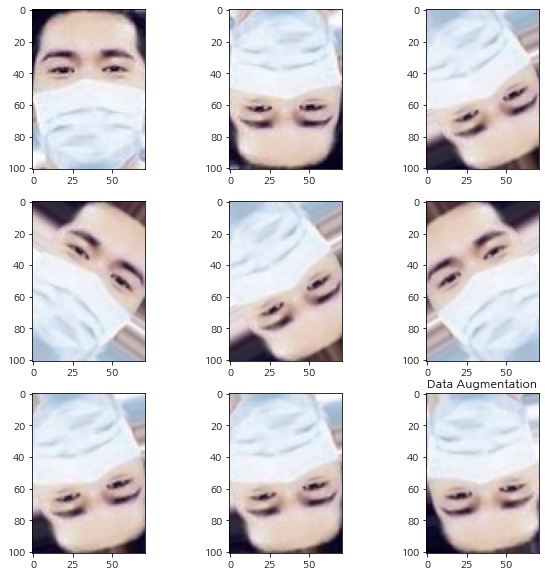

In [11]:
import matplotlib.pyplot as plt

img = load_img('../sungjin/face2/train/with_mask/with_mask_1105.jpg')
data = img_to_array(img)
samples = np.expand_dims(data, 0)

datagen.fit(train_img)
datagen.fit(test_img)


it = datagen.flow(samples, batch_size=32)

fig = plt.figure(figsize = (10,10))

plt.subplot(3,3,1)
plt.imshow(img)

# 9개 이미지 생성
for i in range(8):
    plt.subplot(3, 3, i+2)
    batch = it.next()
    image = batch[0].astype('uint8')
    plt.imshow(image)

# show the figure
plt.title("Data Augmentation")
plt.show()

## Transfer Learning

In [12]:
from keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,AveragePooling2D,Flatten,Dropout,GlobalAveragePooling2D,BatchNormalization, LeakyReLU
import numpy as np
import matplotlib.pyplot as plt
import keras

In [13]:
with tf.device('/gpu:2'):
    base_model = keras.applications.ResNet152(
        include_top=False,
        weights="imagenet",
        input_shape=(224,224,3)
    )
    
    base_model.trainable = False
    
    x = keras.layers.GlobalAveragePooling2D()(base_model.output)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dense(2048,activation= 'relu')(x)
    x = keras.layers.Dropout(0.5)(x)
    predictions = keras.layers.Dense(2,activation = 'sigmoid')(x)
    

    model = keras.models.Model(inputs = base_model.input,outputs =predictions)

    model.compile(optimizer = keras.optimizers.Adam(lr = 0.00001),
                  loss = 'binary_crossentropy',
                  metrics = ['accuracy',])
    
    history = model.fit(datagen.flow(train_img,train_label),
                        validation_data=datagen.flow(test_img,test_label),
                        batch_size = 32,
                        epochs=5)

    model.save("face.h5")

Epoch 1/5
189/189 [==============================] - 74s 392ms/step - loss: 0.2740 - accuracy: 0.8983 - val_loss: 0.0308 - val_accuracy: 0.9926
Epoch 2/5
189/189 [==============================] - 70s 371ms/step - loss: 0.0475 - accuracy: 0.9874 - val_loss: 0.0233 - val_accuracy: 0.9916
Epoch 3/5
189/189 [==============================] - 70s 369ms/step - loss: 0.0295 - accuracy: 0.9922 - val_loss: 0.0135 - val_accuracy: 0.9979
Epoch 4/5
189/189 [==============================] - 70s 369ms/step - loss: 0.0202 - accuracy: 0.9939 - val_loss: 0.0083 - val_accuracy: 0.9979
Epoch 5/5
189/189 [==============================] - 70s 371ms/step - loss: 0.0174 - accuracy: 0.9944 - val_loss: 0.0125 - val_accuracy: 0.9958


In [ ]:
# y_vloss = history.history['val_loss']
# y_loss = history.history['loss']

# x_len = np.arange(len(y_loss))


# plt.plot(x_len, y_vloss, marker='.', c='red', label="Validation-set Loss")
# plt.plot(x_len, y_loss, marker='.', c='blue', label="Train-set Loss")

# plt.legend(loc='upper right')
# plt.grid()
# plt.xlabel('epoch')
# plt.ylabel('loss')
# plt.show()

In [ ]:
# y_vacc = history.history['val_accuracy']
# y_acc = history.history['accuracy']

# x_len = np.arange(len(y_acc))

# plt.plot(x_len, y_vacc, marker='.', c='red')
# plt.plot(x_len, y_acc, marker='.', c='blue')

# plt.grid()
# plt.xlabel('epoch')
# plt.ylabel('accuracy')
# plt.show()

## Predict 

In [14]:
model.predict(samples)

array([[1.0000000e+00, 5.5977537e-13]], dtype=float32)

In [ ]:
from keras.models import load_model

model = load_model("Last.h5")

In [15]:
path = '../sungjin/face2/test/'
subdir = ['with_mask/','without_mask/']
num = 0
idx = 0
count = 0

for sub in subdir:
    num = 0
    count = 0
    print("                                            "+subdir[idx])
    print("--------------------------------------------------------------------------------------")
    for file in os.listdir(path+sub):
        src_path = path + sub+file
        img = load_img(src_path, target_size = (224,224))

        x = img_to_array(img)
        x = np.expand_dims(x, axis=0)
        
        preds = model.predict(x)
        if np.argmax(preds)==idx:
            count+=1
        num = num + 1
        
        
        
    print(" ")
    print("총"+ repr(num)+"개 중에"+repr(count)+"개 맞혔습니다.")
    print(repr((count/num)*100)+"% prediction")
    print()        
    idx +=1
    print(" ")
    


                                            with_mask/
--------------------------------------------------------------------------------------
 
총708개 중에707개 맞혔습니다.
99.85875706214689% prediction

 
                                            without_mask/
--------------------------------------------------------------------------------------
 
총243개 중에241개 맞혔습니다.
99.1769547325103% prediction

 


## Grad-CAM

In [16]:
from keras import layers
from keras import models
from keras import backend as K

import cv2

In [17]:
def gradCAM(image):
    conv_layer = model.get_layer("conv5_block3_3_conv")
    heatmap_model = models.Model([model.inputs],[conv_layer.output,model.output])

    with tf.GradientTape() as gtape:
        conv_output, predictions = heatmap_model(image) # y^c, c
        loss = predictions[:, np.argmax(predictions[0])] # probability
        grads = gtape.gradient(loss, conv_output) # partial-derivative
        pooled_grads = K.mean(grads, axis=(0, 1, 2)) # a_k^c , weight

    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_output), axis=-1) # summation weight * filter
    heatmap = np.maximum(heatmap, 0) # ReLu
    max_heat = np.max(heatmap) # normalization    


    if max_heat == 0:
        max_heat = 1e-10
    heatmap /= max_heat
    
    image = image[0]
    image = cv2.resize(image, (224,224))

    hm = heatmap[0]
    hm = cv2.resize(hm, (image.shape[1],image.shape[0]))
    hm = np.uint8(255*hm)
    hm = cv2.applyColorMap(hm,cv2.COLORMAP_JET)

    cvt_heatmap = cv2.cvtColor(hm, cv2.COLOR_BGR2RGB)

    superimposed_img = cvt_heatmap * 0.9 + image

    superimposed_img[superimposed_img > 255] = 255
    superimposed_img = superimposed_img.astype('uint8')


    return superimposed_img

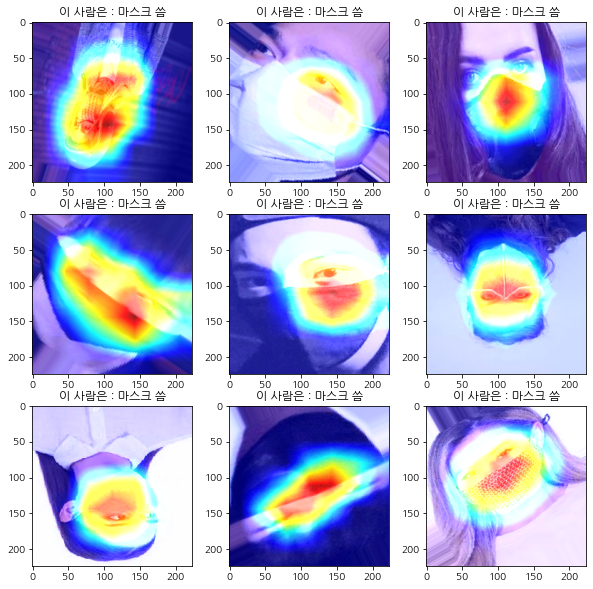

In [28]:
img_path = '../sungjin/face2/test/with_mask/' ### with_mask_1078.jpg # success

fig = plt.figure(figsize = (10,10))
i = 0

for file in os.listdir(img_path):
    
    src = img_path+file
    img = load_img(src, target_size = (224,224))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)

    it = datagen.flow(x, batch_size=32)
    plt.subplot(3,3,i+1)
    batch = it.next()
    image = gradCAM(batch)
    plt.imshow(image)
    predict = np.argmax(model.predict(batch))
    
    if predict == 1:
        labeled = "마스크 안씀"
    else :
        labeled = "마스크 씀"
        
    plt.title("이 사람은 : "+labeled)

    i+=1
    if i == 9:
        break
plt.show()

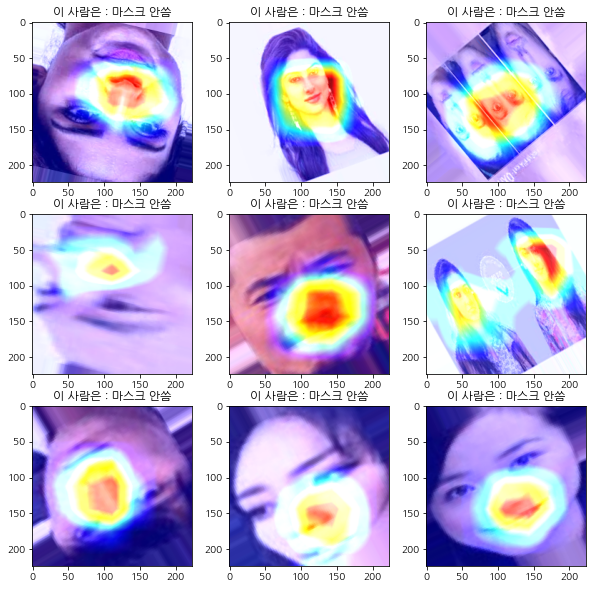

In [27]:
img_path = '../sungjin/face2/test/without_mask/' ### with_mask_1078.jpg # success

fig = plt.figure(figsize = (10,10))
i = 0

for file in os.listdir(img_path):
    
    src = img_path+file
    img = load_img(src, target_size = (224,224))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)

    it = datagen.flow(x, batch_size=32)
    plt.subplot(3,3,i+1)
    batch = it.next()
    image = gradCAM(batch)
    plt.imshow(image)
    predict = np.argmax(model.predict(batch))
    
    if predict == 1:
        labeled = "마스크 안씀"
    else :
        labeled = "마스크 씀"
        
    plt.title("이 사람은 : "+ labeled)

    i+=1
    if i == 9:
        break
plt.show()

## ROC-AUC

In [22]:
import pandas as pd
from sklearn.metrics import roc_auc_score,roc_curve

In [23]:
def rocauc(label_num):
    p = model.predict(test_img, verbose=True)
    pre = pd.DataFrame(p)
    pre["predict"] = pre.idxmax(axis=1)
    pre["predict"] = (pre["predict"]==label_num).apply(int)
    label = np.argmax(test_label,axis = 1).reshape(-1,1)
    pre["label"] = label
    pre["label"] = (pre["label"]==label_num).apply(int)
    tpr,fpr,thres = roc_curve(pre["label"],pre[label_num])
    roc = pd.DataFrame([tpr,fpr]).T
    roc.plot(x=0,y=1)
    print("AUC : "+ repr(roc_auc_score(pre["label"],pre[label_num])))
    

30/30 [==============================] - 2s 71ms/step
AUC : 1.0


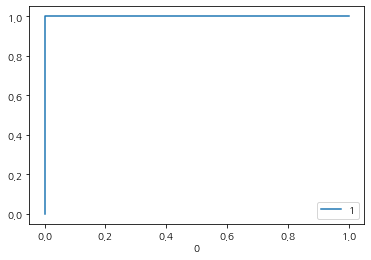

In [24]:
rocauc(0)

30/30 [==============================] - 2s 71ms/step
AUC : 0.9999941875334216


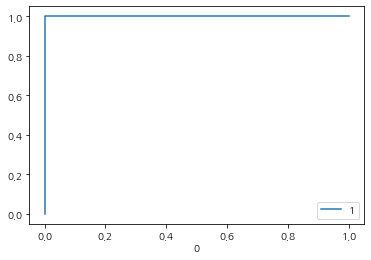

In [25]:
rocauc(1)

## Return GPU resources

In [1]:
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}